# Model to Solve Non-arbitrage Pricing

This is a model established by the Neural Networks Group of the MATH391 course at the **University of Liverpool** for the year 2024, aimed at solving the no-arbitrage problem. The primary reference is: “Incorporating Functional Knowledge in Neural Networks.”
|
Author: ShiYao Gu, JieRui Li, LangMing Liang, MengLei Zhang, SiZhe Jiang, Qi Huang. 

Project Supervisor: Youness Boutaib, Samira Amiriyan

Module Supervisor: Corina Constantinescu

# Principle of the Model

According to the artical, the model we want to implement is: 

$ C = C(K, T) $ (Here, we are no interest in other parameters)
- C is the price of this call option
- K is the strick price
- T is the time to maturity

And here, in order to insure the property of "Non-arbitrage", we need the following property:

$f \geq 0, \quad \frac{\partial f}{\partial x_1} \geq 0, \quad \frac{\partial f}{\partial x_2} \geq 0, \quad \frac{\partial^2 f}{\partial x_1^2} \geq 0$

that is: (take $-K$)

$ f \geq 0, \quad \frac{\partial f}{\partial T} \geq 0, \quad \frac{\partial f}{\partial K} \leq 0, \quad \frac{\partial^2 f}{\partial K^2} \geq 0$

Therefore, according to the artical: "Incorporating Functional Knowledge in Neural Networks". The following structure of NN will be used. 

$c, n \hat{\mathcal{N}}_{++}=\left\{f(x)=e^{w_0}+\sum_{i=1}^H e^{w_i}\left(\prod_{j=1}^c \zeta\left(b_{i j}+e^{v_{i j}} x_j\right)\right)\left(\prod_{j=c+1}^n h\left(b_{i j}+e^{v_{i j}} x_j\right)\right)\right\}$

- Notice that here, we only have two parameters, that is $K,T$, thus we should take $n=2, c=1$

More detailed structure is shown on the PPT.

Let’s now take a look at our upcoming implementation plan:

- Step01: Define the forward propagation

- Step02: Import dataset

- Step03: Randomly splits training and testing datasets

- Step04: Optimize the model using PyTorch

- Step05: Make prediction model


Here's all the package we need:

In [1]:
# pip install torch
# pip install pandas
# pip install openpyxl

# Step01: Define forward propagation 

The first step we need to take is to prepare the two activation functions required for the forward propagation.

- sigmoid: $h(s)=1 /\left(1+e^{-s}\right)$
- softplus: $\zeta(s)=\ln \left(1+e^s\right)$

In [2]:
import torch
import torch.nn.functional as F

def softplus(x):
    return F.softplus(x)

def sigmoid(x):
    return torch.sigmoid(x)

Based on the above model, we provide the implementation method for forward propagation.

$c, n \hat{\mathcal{N}}_{++}=\left\{f(x)=e^{w_0}+\sum_{i=1}^H e^{w_i}\left(\prod_{j=1}^c \zeta\left(b_{i j}+e^{v_{i j}} x_j\right)\right)\left(\prod_{j=c+1}^n h\left(b_{i j}+e^{v_{i j}} x_j\right)\right)\right\}$

This is what our parameters look like: (Pay very very much attention to deminsion)

$V=\left(\begin{array}{cc}v_{11} & v_{12} \\ v_{21} & v_{22} \\ \vdots &\vdots \\ v_{H 1} & v_{H2}\end{array}\right) \quad b=\left(\begin{array}{cc}b_{11} & b_{12} \\ b_{21} & b_{22} \\ \vdots& \vdots \\ b_{H1} & b_{H2}\end{array}\right)$

$w=\left(w, w_2, w_3, w_4 \cdots w_H\right)$

$w_0 \in R $

In [3]:
def forward_propagation(V, b, w, w0, x):
    """
    Perform forward propagation using PyTorch.
    
    Arguments:
    V -- weight matrix for the first layer
    b -- bias matrix for the first layer
    w -- weight vector for the output layer
    w0 -- bias scalar for the output layer
    x -- input data matrix
    
    Returns:
    result -- the output of the forward propagation
    """
    V_first_column = V[:, 0].reshape(-1, 1)
    V_second_column = V[:, 1].reshape(-1, 1)
    x_first_row = x[0, :].reshape(1, -1)
    x_second_row = x[1, :].reshape(1, -1)
    b_first_column = b[:, 0].reshape(-1, 1)
    b_second_column = b[:, 1].reshape(-1, 1)
    
    parameters_ready_to_apply_softplus = torch.mm(torch.exp(V_first_column), x_first_row) + b_first_column
    parameters_ready_to_apply_sigmoid = torch.mm(torch.exp(V_second_column), x_second_row) + b_second_column
    
    after_softplus = softplus(parameters_ready_to_apply_softplus)
    after_sigmoid = sigmoid(parameters_ready_to_apply_sigmoid)

    layer1 = after_softplus * after_sigmoid

    result = torch.mm(torch.exp(w).unsqueeze(0), layer1) + torch.exp(w0)
    
    return result

# Define the Lost Function

Here we just compute MSE: 

$ \text{MSE} = \frac{1}{m} \sum_{i=1}^{m} (AL_i - y_i)^2 $

In [4]:
def mean_squared_error(AL, Y):
    """
    Calculate Mean Squared Error (MSE) using PyTorch.
    
    Parameters:
    AL -- predicted values tensor
    Y -- true labels tensor
    
    Returns:
    mse -- mean squared error tensor
    """
    mse = torch.mean((AL - Y) ** 2)
    return mse

# Step02: Import Dataset

Here we have written a method for reading data.

Warnings: 
- openpyxl package required
- When using this method, please correct the path to the path of the spreadsheet on the current computer.

In [5]:
import pandas as pd
from datetime import datetime

def read_option_data(file_path, ticker, current_date):

    """
    Reads option data from an Excel file, filters it based on the given ticker and option type 'Call',
    calculates the days to expiration from the current_date, and returns matrices of strikes with days to expiration,
    and stock prices.
    
    Parameters:
    file_path (str): The path to the Excel file.
    ticker (str): The ticker symbol to filter the data.
    current_date (datetime): The current date for calculating days to expiration.
    
    Returns:
    tuple: Two matrices, one for strikes and days to expiration, and one for stock prices.
    """

    
    # Read the Excel file
    df = pd.read_excel(file_path)
    
    # Filter data for the specified ticker and for Call options
    df_filtered = df[(df['Ticker'] == ticker) & (df['Type'] == 'Call')].copy()
    
    # Convert Expiration(T) to datetime
    df_filtered['Expiration(T)'] = pd.to_datetime(df_filtered['Expiration(T)'])
    
    # Calculate the difference in days between Expiration(T) and current_date
    df_filtered['Days to Expiration'] = (df_filtered['Expiration(T)'] - current_date).dt.days
    
    # Extract K, Days to Expiration and T columns to form one matrix
    K_T_matrix = df_filtered[['Strike(K)', 'Days to Expiration']].values
    
    # Extract S column to form another matrix
    c_matrix = df_filtered[['Last Option Price (c)']].values
    
    return K_T_matrix.T, c_matrix.T

Then, we know that we should have : 

$ f \geq 0, \quad \frac{\partial f}{\partial T} \geq 0, \quad \frac{\partial f}{\partial K} \leq 0, \quad \frac{\partial^2 f}{\partial K^2} \geq 0$

So we take $ K $ as the first element, and take $ K $ as $-K$

In [6]:
def negate_first_row(matrix):
    """
    Negates the elements of the first row of the given matrix.

    Parameters:
    matrix (numpy.ndarray): The input matrix whose first row elements will be negated.

    Returns:
    numpy.ndarray: The modified matrix with the first row elements negated.
    """
    
    # Negate the first row of the matrix
    matrix[0] = -matrix[0]
    
    return matrix

Next, we read the relevant data, but in this program, we only analyzed the data related to Apple Inc.

In [7]:
x_apple, y_apple = read_option_data('/Users/shiyaogu/Documents/Modules in UoL/MATH 391/Attempt/options_data-2.xlsx', "AAPL",  datetime(2024, 6, 26))
x_tesla, y_tesla = read_option_data('/Users/shiyaogu/Documents/Modules in UoL/MATH 391/Attempt/options_data-2.xlsx', "TSLA",  datetime(2024, 6, 26))
x_apple_final = torch.tensor(negate_first_row(x_apple), dtype = torch.float32)
x_tesla_final = torch.tensor(negate_first_row(x_tesla), dtype = torch.float32)
y_apple_final = torch.tensor(y_apple, dtype = torch.float32)
y_tesla_final = torch.tensor(y_tesla, dtype = torch.float32)

# Step03: Randomly splits training and testing datasets

Here, we have improved the previous method of separating training data and test data. We have adopted a strategy of randomly splitting the data.

In [8]:
import torch

def split_train_test(matrix1, matrix2, ratio):
    """
    Randomly splits two given matrices into training and testing datasets based on a given ratio.
    
    Parameters:
    matrix1 (torch.Tensor): The first input matrix.
    matrix2 (torch.Tensor): The second input matrix.
    ratio (float): The ratio of columns to include in the training data (0 < ratio < 1).
    
    Returns:
    tuple: Four matrices: train_matrix1, test_matrix1, train_matrix2, test_matrix2
    """
    # Ensure the input ratio is between 0 and 1
    if not (0 < ratio < 1):
        raise ValueError("The ratio must be a float between 0 and 1")
    
    # Calculate the number of columns for training based on the ratio
    n = int(matrix1.shape[1] * ratio)
    
    # Ensure the input matrices have enough columns
    if matrix1.shape[1] < n or matrix2.shape[1] < n:
        raise ValueError("The input matrices must have enough columns to split based on the ratio")
    
    # Randomly shuffle the indices of columns
    indices = torch.randperm(matrix1.shape[1])
    train_indices = indices[:n]
    test_indices = indices[n:]
    
    # Split the first matrix
    train_matrix1 = matrix1[:, train_indices]
    test_matrix1 = matrix1[:, test_indices]
    
    # Split the second matrix
    train_matrix2 = matrix2[:, train_indices]
    test_matrix2 = matrix2[:, test_indices]
    
    return train_matrix1, test_matrix1, train_matrix2, test_matrix2

In [9]:
train_x_apple, test_x_apple, train_y_apple, test_y_apple = split_train_test(x_apple_final, y_apple_final, 0.9)
train_x_tesla, test_x_tesla, train_y_tesla, test_y_tesla = split_train_test(x_tesla_final, y_tesla_final, 0.9)
print(train_x_apple.shape)
print(train_y_apple.shape)

torch.Size([2, 824])
torch.Size([1, 824])


# Step04: Optimize the model using PyTorch

In [10]:
import torch.optim as optim

# Hyperparameters
H = 10
input_dim = 2  # Dimension of x_apple

# Initialize parameters
V = torch.randn(H, 2, requires_grad=True, dtype=torch.float32)
b = torch.randn(H, 2, requires_grad=True, dtype=torch.float32)
w = torch.randn(H, requires_grad=True, dtype=torch.float32)
w0 = torch.randn(1, requires_grad=True, dtype=torch.float32)

# Optimizer
optimizer = optim.Adam([V, b, w, w0], lr=0.01)

# Training loop
num_epochs = 50000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    # Forward propagation
    y_pred = forward_propagation(V, b, w, w0, train_x_apple)
    
    # Compute loss
    loss = mean_squared_error(y_pred, train_y_apple)
    
    # Backward propagation and optimization
    loss.backward()
    optimizer.step()
    
    # Print loss every 1000 iterations
    if (epoch + 1) % 1000 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

print("Optimization finished")
optimal_V = V
optimal_b = b
optimal_w = w
optimal_w0 = w0

Epoch [1000/50000], Loss: 96.0910
Epoch [2000/50000], Loss: 79.0407
Epoch [3000/50000], Loss: 61.2963
Epoch [4000/50000], Loss: 53.1103
Epoch [5000/50000], Loss: 50.3014
Epoch [6000/50000], Loss: 49.1249
Epoch [7000/50000], Loss: 48.0327
Epoch [8000/50000], Loss: 47.7260
Epoch [9000/50000], Loss: 47.5797
Epoch [10000/50000], Loss: 47.4779
Epoch [11000/50000], Loss: 47.3990
Epoch [12000/50000], Loss: 47.3265
Epoch [13000/50000], Loss: 47.2558
Epoch [14000/50000], Loss: 47.1888
Epoch [15000/50000], Loss: 47.1294
Epoch [16000/50000], Loss: 47.0815
Epoch [17000/50000], Loss: 47.0419
Epoch [18000/50000], Loss: 47.0126
Epoch [19000/50000], Loss: 46.9905
Epoch [20000/50000], Loss: 46.9738
Epoch [21000/50000], Loss: 46.9610
Epoch [22000/50000], Loss: 46.9509
Epoch [23000/50000], Loss: 46.9441
Epoch [24000/50000], Loss: 46.9365
Epoch [25000/50000], Loss: 46.9311
Epoch [26000/50000], Loss: 46.9267
Epoch [27000/50000], Loss: 46.9229
Epoch [28000/50000], Loss: 46.9197
Epoch [29000/50000], Loss: 46

# Step05: Make prediction model

Here, our method will return a model using the optimized parameters.

In [11]:
def get_predict_function(V, b, w, w0):
    """
    Returns a prediction function using the learned parameters.

    Parameters:
    V (torch.Tensor): Learned parameter V.
    b (torch.Tensor): Learned parameter b.
    w (torch.Tensor): Learned parameter w.
    w0 (torch.Tensor): Learned parameter w0.

    Returns:
    function: A function that takes input data x and returns predictions.
    """
    def predict(x):
        """
        Predict using the learned parameters.

        Parameters:
        x (torch.Tensor): Input data of shape (n_samples, 2).

        Returns:
        torch.Tensor: The predicted values.
        """
        return forward_propagation(V,b,w,w0,x)

    return predict

In [12]:
final_model = get_predict_function(optimal_V, optimal_b, optimal_w, optimal_w0)

In [13]:
y_predict = final_model(test_x_apple)

In [14]:
print(test_y_apple)

tensor([[1.2000e-01, 1.0584e+02, 4.0000e-02, 7.8220e+01, 1.0997e+02, 1.3904e+02,
         1.4650e+02, 7.0000e-02, 6.1950e+01, 5.0000e-02, 1.3546e+02, 6.9500e+00,
         8.0000e+01, 1.2360e+01, 7.0430e+01, 1.8000e-01, 7.0000e-02, 1.3868e+02,
         3.1640e+01, 1.1615e+02, 1.4150e+02, 3.0000e-01, 2.0000e-02, 5.7000e+00,
         7.9500e+01, 1.7100e+00, 4.2100e+00, 2.5000e-01, 2.4000e-01, 6.8700e+01,
         5.1480e+01, 1.4200e+01, 1.5477e+02, 2.5950e+01, 3.8550e+01, 5.9000e+01,
         1.6300e+01, 2.0700e+02, 5.8000e-01, 9.2300e+01, 1.4070e+01, 7.8000e-01,
         4.5000e-01, 6.6100e+00, 2.5940e+01, 1.8450e+01, 1.1335e+02, 2.8900e+00,
         1.0601e+02, 5.4070e+01, 1.1400e+00, 1.2982e+02, 4.3550e+01, 9.7000e+00,
         1.3007e+02, 2.0458e+02, 7.3920e+01, 1.6650e+01, 1.1863e+02, 8.1820e+01,
         7.5550e+01, 1.1895e+02, 1.1000e+01, 4.0650e+01, 6.3760e+01, 2.0000e-02,
         8.9300e+00, 9.1350e+01, 2.3700e+00, 1.8220e+01, 2.5350e+01, 4.5000e-01,
         4.0000e-02, 2.7000e

In [15]:
print(mean_squared_error(y_predict, test_y_apple))

tensor(43.1118, grad_fn=<MeanBackward0>)


# Extra Step: Analysis of the model

First, we will plot an image to roughly observe how the model fits on the test data set.

In [16]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

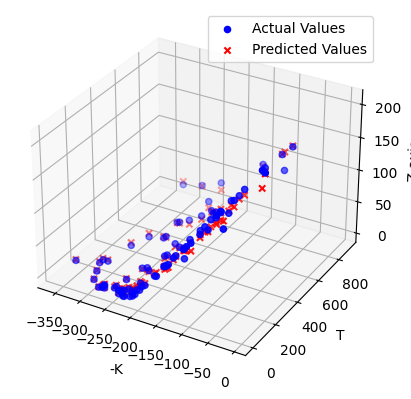

In [17]:
test_x_apple_np = test_x_apple.detach().numpy()
test_y_apple_np = test_y_apple.detach().numpy()
y_predict_np = y_predict.detach().numpy()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


ax.scatter(test_x_apple_np[0], test_x_apple_np[1], test_y_apple_np, c='blue', marker='o', label='Actual Values')


ax.scatter(test_x_apple_np[0], test_x_apple_np[1], y_predict_np, c='red', marker='x', label='Predicted Values')


ax.set_xlabel('-K')
ax.set_ylabel('T')
ax.set_zlabel('Z axis')


ax.legend()


plt.show()

We can observe that the predicted values of the data points are quite close to the actual values.

Next, let’s analyze the differences in the loss function exhibited by the model for different numbers of neurons.

First, we noticed an issue: during the model training process, we found that the loss function converges to a value that is not zero. We believe this is because this value represents the best result the model can achieve given the current structure. That is, it is limited by the model structure (in this case, the number of neurons). Additionally, the fitting target in our research direction (K, T) does not exhibit particularly strong patterns, so it cannot converge to zero.

Epoch [1000/5000], Loss: 82.0593
Epoch [2000/5000], Loss: 60.7902
Epoch [3000/5000], Loss: 53.5727
Epoch [4000/5000], Loss: 50.3834
Epoch [5000/5000], Loss: 48.7720
Optimization finished


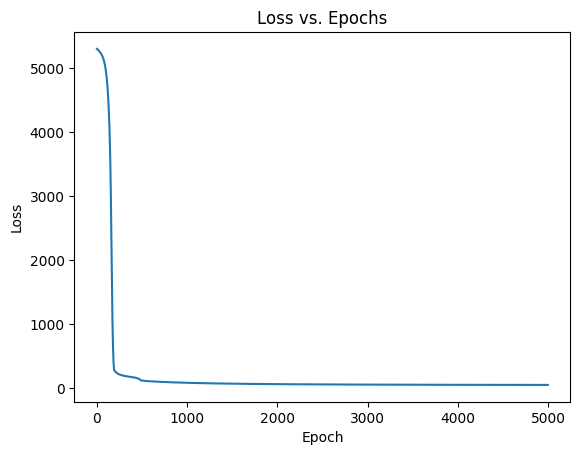

In [19]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt

# Hyperparameters
H = 10
input_dim = 2  # Input dimension

# Initialize parameters
V = torch.randn(H, 2, requires_grad=True, dtype=torch.float32)
b = torch.randn(H, 2, requires_grad=True, dtype=torch.float32)
w = torch.randn(H, requires_grad=True, dtype=torch.float32)
w0 = torch.randn(1, requires_grad=True, dtype=torch.float32)

# Optimizer
optimizer = optim.Adam([V, b, w, w0], lr=0.01)

# Training loop
num_epochs = 5000
losses = []

for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    # Forward propagation
    y_pred = forward_propagation(V, b, w, w0, train_x_apple)
    
    # Compute loss
    loss = mean_squared_error(y_pred, train_y_apple)
    
    # Backward propagation and optimization
    loss.backward()
    optimizer.step()
    
    # Save loss value
    losses.append(loss.item())
    
    # Print loss every 1000 iterations
    if (epoch + 1) % 1000 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

print("Optimization finished")

# Plot loss vs. epochs
plt.plot(range(num_epochs), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epochs')
plt.show()

Finally, the table below shows the relationship between the number of neurons and the convergence results of the loss function.

| H     | Loss     |
| :-----: | :-----: |
| 1 | 64.7333|
| 2 | 62.379 |
| 3 | 45.1903 |
| 4 |  45.0423 |
| 5 | 44.711 |
| 10 | 44.7529 |
| 100 | 44.8589 |
| 1000 | 41.4791 |